In [19]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import Sequence
import numpy as np
import os

# Training parameters
batch_size = 128
epochs = 50
data_augmentation = True
num_classes = 10

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_val = x_test
y_val = y_test
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
#subtract_pixel_mean = True

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


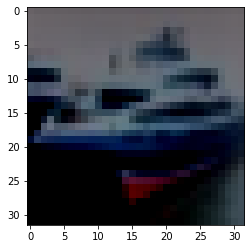

In [20]:
import matplotlib.pyplot as plt

plt.imshow(x_test[1])    # Plot the first sample: sanity check
plt.show()


In [0]:

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-2
    if epoch > 50:
        lr *= 0.5e-3
    elif epoch > 42:
        lr *= 1e-1
    elif epoch > 30:
        lr *= 1e-2
    elif epoch > 11:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [12]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True,
                 dropout=0):
  
    #TODO: add dropout
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  use_bias=False,
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if dropout > 0:
            x = Dropout(dropout)(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if dropout > 0:
            x = Dropout(dropout)(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1_block(x, num_filters, downscale=False, first=False):
  
  # Residual path
  y = resnet_layer(inputs=x, num_filters=num_filters, strides = (2 if downscale else 1))
  y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)

  # identity. Need to match the output for addition
  if first or downscale:
    x = resnet_layer(inputs=x, num_filters=num_filters, kernel_size=1, strides = (2 if downscale else 1),  batch_normalization=False, activation=None)

  # add
  x = keras.layers.add([x, y])
  x = Activation('relu')(x)
  return x
  
def resnet_v1(input_shape, res_blocks, num_classes=10):
    # Start model definition.
    num_filters = 16

    inputs = Input(shape=input_shape)

    # first convolution before Resnet starts.
    # Should this be done, because we dont want to modify the input
    # But in actual resnet they are doing 7x7, may be they are not doing BN or activation here!!!
    x = resnet_layer(inputs=inputs, num_filters=num_filters)

    # Instantiate the stack of residual units
    for i, blockcount in enumerate(res_blocks):
        num_filters = num_filters*2
        #num_filters *= 2
        for layer in range(blockcount):
          x = resnet_v1_block(x, num_filters=num_filters, downscale=i>1 and layer==0, first = layer==0 and i<2)

    # Add classifier on top.
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes,
                    activation='softmax', use_bias=False,
                    kernel_initializer='he_normal')(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def lr_schedule(epoch):
    lr = 0.003 * pow(0.5, epoch//5)
    print("Learning rate = ", lr)
    return lr

model = resnet_v1(input_shape=input_shape, res_blocks=(2, 2, 2, 2))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_Resnet18.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)


# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w # area of cutout
            r = np.random.uniform(r_1, r_2) # 
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=20,
        # randomly shift images horizontally
        width_shift_range=0.2,
        # randomly shift images vertically
        height_shift_range=0.2,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.2,
        # set range for random channel shifts
        channel_shift_range=0,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    train_iter = NumpyArrayIterator(x=x_train, y=y_train, image_data_generator=datagen, batch_size=batch_size, shuffle=True)
    val_iter = NumpyArrayIterator(x=x_test, y=y_test, image_data_generator=datagen, batch_size=batch_size, shuffle=True)

    model.fit_generator(generator = train_iter,
                        steps_per_epoch = (x_train.shape[0]//batch_size), epochs = 50, 
                        validation_data = val_iter, verbose=1, workers=4, callbacks=callbacks)

Learning rate =  0.003
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 32, 32, 16)   432         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 32, 32, 16)   64          conv2d_42[0][0]                  
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 32, 32, 16)   0           batch_normalization_34[0][0]     
_____________________________________________________________________

In [13]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 3s 251us/sample - loss: 0.4569 - acc: 0.9069
Test loss: 0.4568828545093536
Test accuracy: 0.9069


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


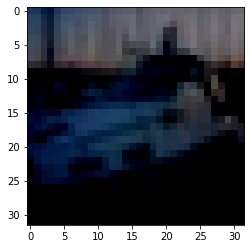

In [21]:
import matplotlib.pyplot as plt

plt.imshow(x_test[2]) 
plt.show()

In [0]:
from google.colab.patches import cv2_imshow

def GradCamImpl(img):
  #img = io.imread(input_img)
  #img = cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x =x.astype('float32') / 255
  #x = preprocess_input(x)

  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  print(class_idx)
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("activation_50")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(32):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
 
  heatmap = np.mean(conv_layer_output_value, axis = -1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
  img_resized = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  superimposed_img_resized = cv2.resize(superimposed_img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  heatmap_resized = cv2.resize(heatmap, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  cv2_imshow(img_resized)
  cv2_imshow(superimposed_img_resized)
  #cv2_imshow(heatmap_resized)
  print("------------------------------------------")

3


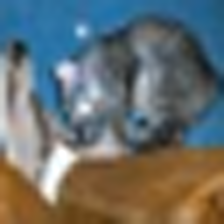

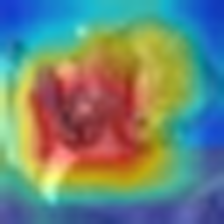

------------------------------------------
8


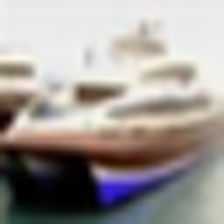

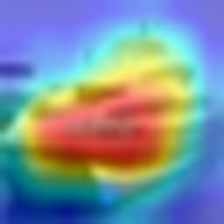

------------------------------------------
8


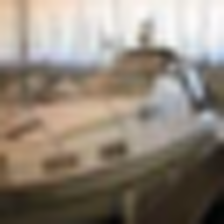

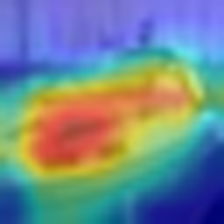

------------------------------------------
8


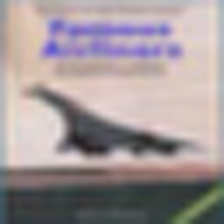

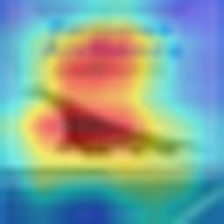

------------------------------------------
6


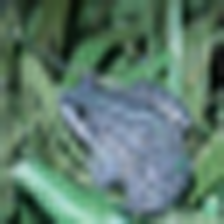

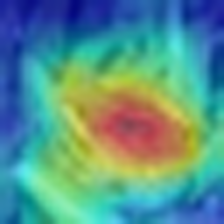

------------------------------------------
6


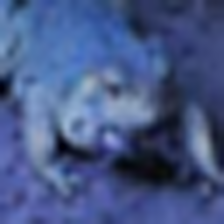

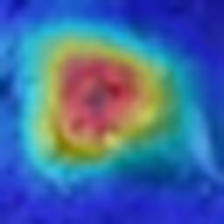

------------------------------------------
1


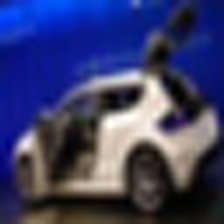

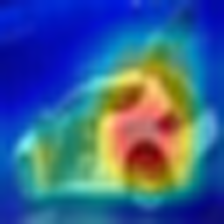

------------------------------------------
6


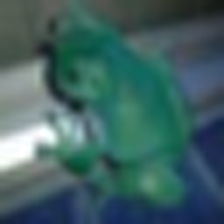

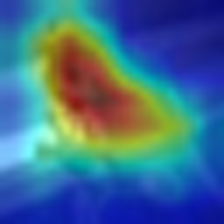

------------------------------------------
3


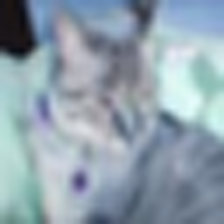

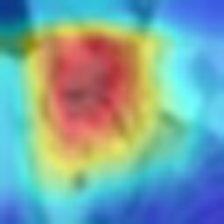

------------------------------------------
1


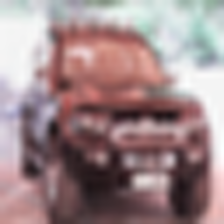

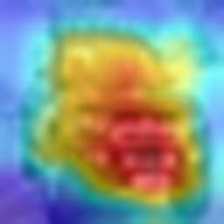

------------------------------------------


In [41]:
for x in range(10):
  GradCamImpl(x_val[x])